# Forecasting Atmospheric CO2


### Introduction

For this case-study, we are utilizing the CO2 concentrations at the Mauna Lao observatory in Hawaii. The CO2 concentrations are recorded in ppm since the last 1950s. [More Information](https://www.esrl.noaa.gov/gmd/ccgg/trends/).

> The graphs show monthly mean carbon dioxide measured at Mauna Loa Observatory, Hawaii. The carbon dioxide data (red curve), measured as the mole fraction in dry air, on Mauna Loa constitute the longest record of direct measurements of CO2 in the atmosphere. They were started by C. David Keeling of the Scripps Institution of Oceanography in March of 1958 at a facility of the National Oceanic and Atmospheric Administration (NOAA)

The data has been got from the [following link](https://datahub.io/core/co2-ppm). 

### Goal

To forecast the monthly average CO2 concentration of 2018 and 2019. 

As per [this link](https://www.esrl.noaa.gov/gmd/ccgg/trends/). The CO2 concentrations at Sepetember 2018 and Sepetember 2019 were 405.51ppm and 408.54ppm respectively. For these months, we'll see if we are able to get forecasts that are reasonably accurate.


### Result Summary


### Approach Summary


### Table of Contents
1. Getting and setting-up the data
2. Data Exploration 
3. A naiive (baseline) model using Holt-Winters Method (Triple Exponential Smoothening)
4. An ARIMA based Model
5. Summary

***

### 1. Getting and Setting-up Data

In [2]:
# Initial Housekeeping

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Atmospheric_CO2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

#create the reqired folders if they don't already exist
os.makedirs(IMAGES_PATH, exist_ok=True)

# A simple function that helps save images
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)



In [41]:
# Housekeeping, Part 2

# to make the plots larger in size
from pylab import rcParams
rcParams['figure.figsize'] = 16,10


# A set of libraries pertaining to forecasting methods

from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

In [4]:
# Getting the data

df = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/time_series/co2_mm_mlo.csv")


In [5]:
# having a quick look at the data
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [6]:
df.tail()

,year,month,decimal_date,average,interpolated
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00
728,2018,11,2018.875,408.02,408.02


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 5 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
dtypes: float64(3), int64(2)
memory usage: 28.6 KB


So, as mentioned above this data-set is perhaps one of the select few that track a data-point over 60+ years.

There is no 'date' field and it has to be reconstituted from the month and the year fields.

This dataset is already treated for missing values (`interpolated` field). The forecasts and the models will be build on this field.

In [8]:
df['date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
date            729 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.2 KB


In [10]:
df = df.set_index('date')

In [11]:
df.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', name='date', length=729, freq=None)

In [12]:
df.index.freq = 'MS'

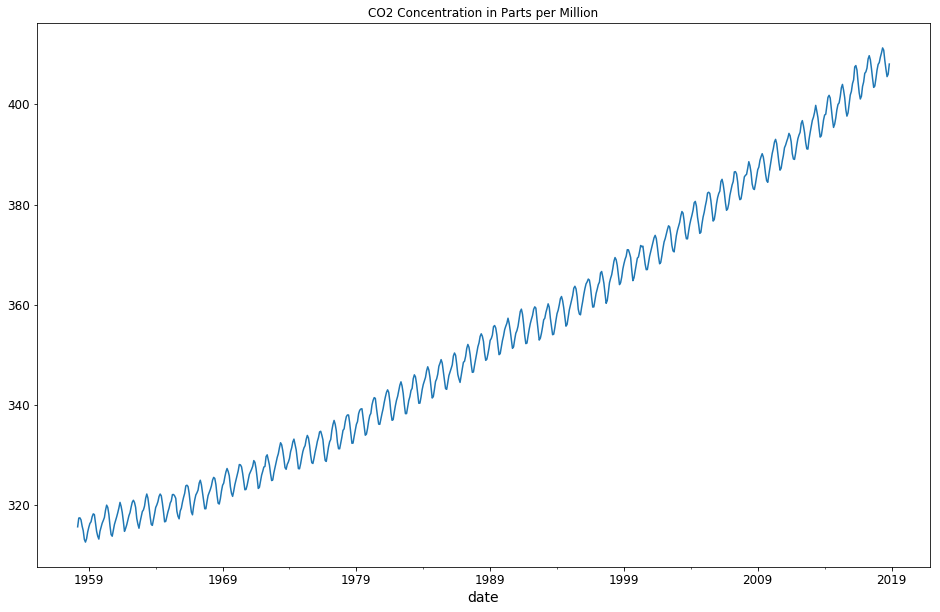

In [13]:
# Plotting the data
df['interpolated'].plot(title = "CO2 Concentration in Parts per Million")

Before we go any further along the analysis,we will divide the data into training and testing sets. The last 24 months of data will be set aside for validation purposes i.e. testing set.

In [14]:
train = df.iloc[:705]
test = df.iloc[705:]

test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2016-12-01 to 2018-11-01
Freq: MS
Data columns (total 5 columns):
year            24 non-null int64
month           24 non-null int64
decimal_date    24 non-null float64
average         24 non-null float64
interpolated    24 non-null float64
dtypes: float64(3), int64(2)
memory usage: 1.1 KB


***

### 2. Exploring the Data

In this section, we shall be exploring ETS Decomposition and Stationarity.

Stating out with ETS Decomposition first.

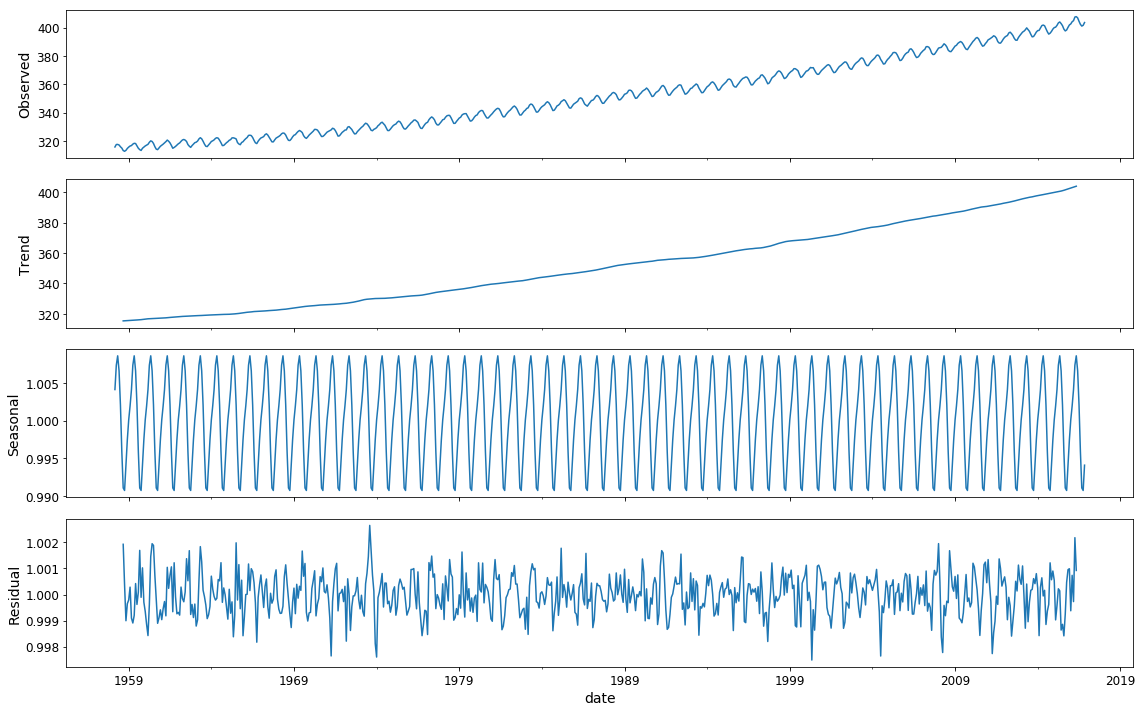

In [40]:
# Seasonal Decompose to get ETS components
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['interpolated'], model = 'mul')
result.plot();

Trying out both the *additive* and *multiplicative* versions of ETS decomposition, we find that there is seasonality albeit limited in magnitude.

Will be trying out monthly plot next to get a better understanding of seasonality.

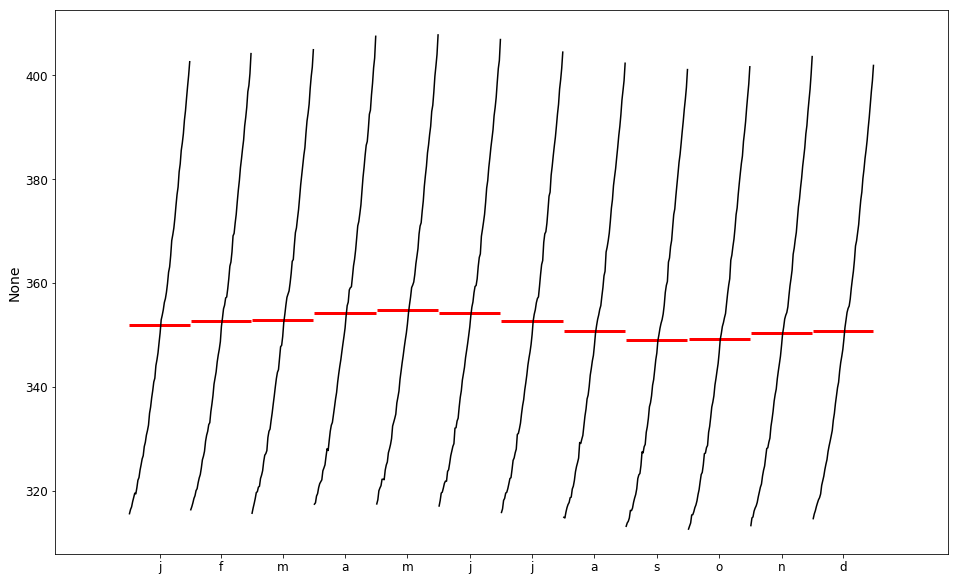

In [17]:
# Plotting a month plot to better understand the seasonality

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(train['interpolated']);

The seasonal component seems to be small.

Next up, we will be evaluating stationarity by performing the Augmented Dickey Fuller Test.

In [18]:
# Augmented Dickey Fuller Test

# RUN AUGMENTED D-F TEST TO TEST FOR STATIONARITY
# using that kickass tool which was developed earlier by us
# *********************************************************

# A CUSTOM FUNCTION TO INTERPRET THE RESULTS OF THE AUGMENTED D-F TEST

def adf_test(series,title=''):
    """
    Input: 
          Pass in a time series and an optional title, 
    Returns, an ADF report
    """
    
    print("*******************************************")
    print(f'Augmented Dickey-Fuller Test: {title}')
    print("\n")
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    print("\n")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    print("*******************************************")


In [19]:
adf_test(train['interpolated'])

*******************************************
Augmented Dickey-Fuller Test: 


ADF test statistic        4.807049
p-value                   1.000000
# lags used              20.000000
# observations          684.000000
critical value (1%)      -3.439947
critical value (5%)      -2.865775
critical value (10%)     -2.569025


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
*******************************************


The data is non-stationary and we'll have to difference it to make it stationary.

***

### 3. A Naive Model using Holt-Winter's Method

Starting off by implementing the Holt's method first, which does not account for seasonality.

#### Holt's Method - Double Exponential Smoothening
Using `trend` as additive

In [29]:
double_exp_model = ExponentialSmoothing(train['interpolated'],trend = 'add')

fitted_model_DES = double_exp_model.fit()

train['DES_model'] = fitted_model.fittedvalues.shift(-1)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


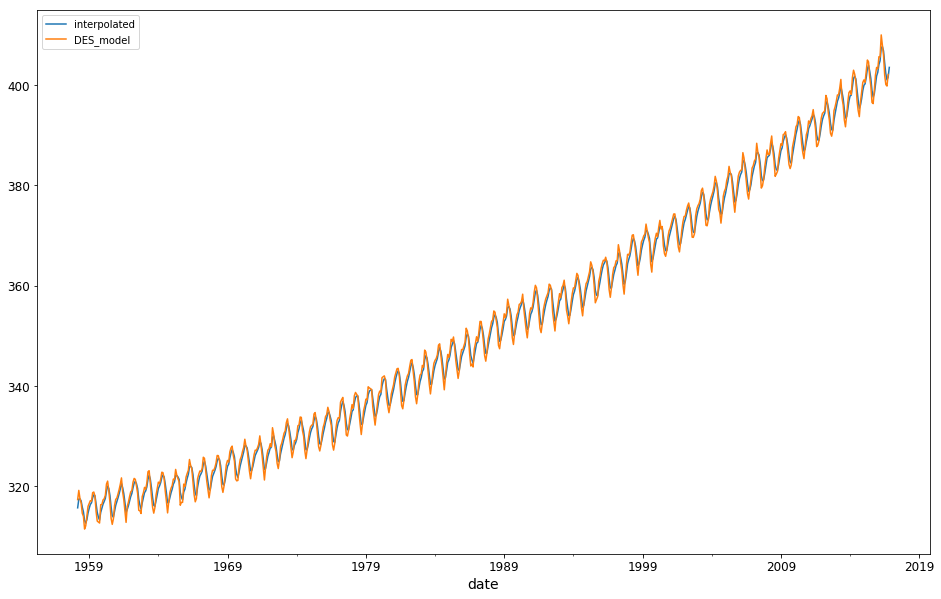

In [22]:
# Plotting the DES model against the original data
train[['interpolated','DES_model']].plot(legend = True)

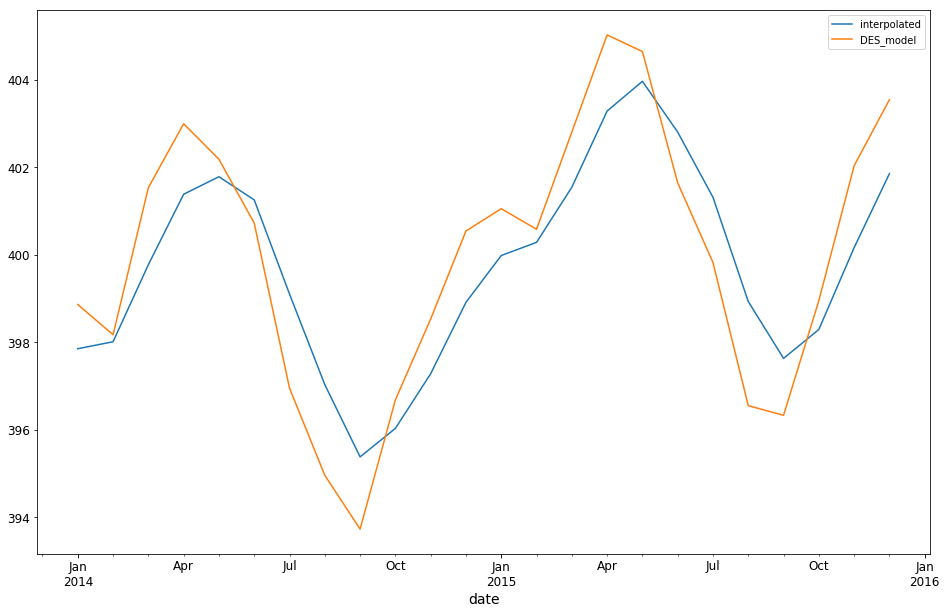

In [27]:
# Zoom in to have a better look, focusssing on 2014-15

train[['interpolated','DES_model']]['2014-01-01':'2015-12-01'].plot(legend = True)

The Double Exponential Smoothing results looks reasonably well.

#### Holt Winter's Method - Triple Exponential Smoothening

Using `trend` and `seasonality` as *multiplicative*. Setting the number of `seasonal_periods` as 12 (yearly)

In [30]:
triple_exp_model = ExponentialSmoothing(train['interpolated'],trend = 'add', seasonal = 'add', seasonal_periods = 12)

fitted_model_TES = triple_exp_model.fit()

train['TES_model'] = fitted_model.fittedvalues


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


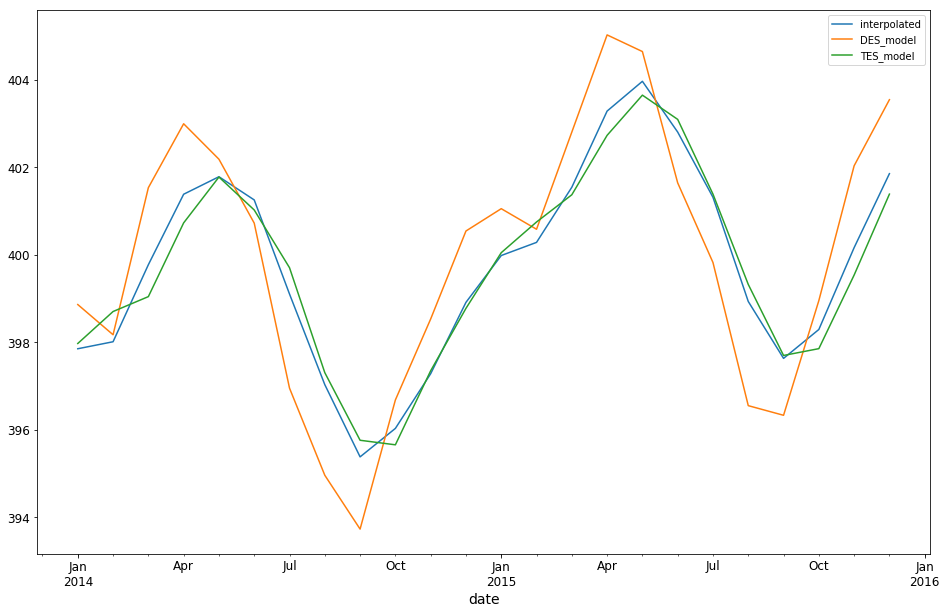

In [28]:
# Looking at the TES forecasts, Zoom in to have a better look, focusssing on 2014-15

train[['interpolated','DES_model','TES_model']]['2014-01-01':'2015-12-01'].plot(legend = True)

The Triple Exponential Smoothing results performs quite well.

#### Double and Triple Exponential Models: The Forecasts
To get a concere sense on how well the Holt's and Holt - Winter's models perform.

Two things:
1. Evaluating forecasts on test set using RMSE as the KPI
2. Evaluating the foreacsts for September 2018 and 2019

In [31]:
test_predictions_DES = fitted_model_DES.forecast(24)
test_predictions_TES = fitted_model_TES.forecast(24)

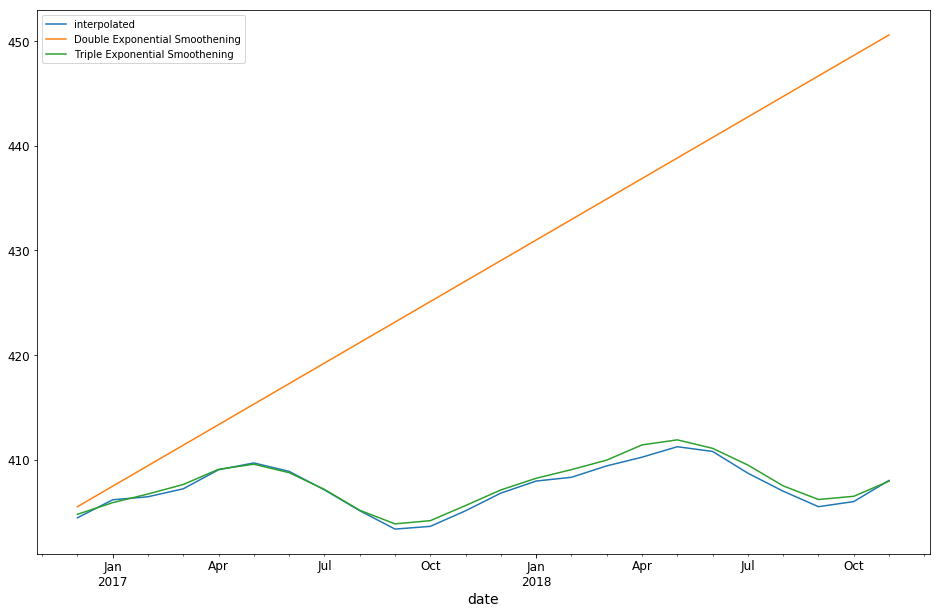

In [32]:
# Plotting Test predictions against the test set
test['interpolated'].plot(legend = True)
test_predictions_DES.plot(legend = True, label = "Double Exponential Smoothening")
test_predictions_TES.plot(legend = True, label = "Triple Exponential Smoothening")

In [35]:
# Evaluating the RMSE for the Triple Exponential Smoothing Model

mse = mean_squared_error (test['interpolated'],test_predictions_TES)

print(" RMSE for the Triple Exponential Smoothening Model : ", np.sqrt(mse))

 RMSE for the Triple Exponential Smoothening Model :  0.4895379882245184


We can make a *decisive comment* on this post looking at the RMSE from training the ARIMA model.

In [39]:
# Evaluating the forecast for September 2018 and September 2019

test_predictions_TES_36 = fitted_model_TES.forecast(36)

test_predictions_TES_36[20:34]

2018-08-01    407.498571
2018-09-01    406.198412
2018-10-01    406.503589
2018-11-01    407.950401
2018-12-01    409.440893
2019-01-01    410.554681
2019-02-01    411.378811
2019-03-01    412.289598
2019-04-01    413.743108
2019-05-01    414.224900
2019-06-01    413.416759
2019-07-01    411.817656
2019-08-01    409.827307
2019-09-01    408.527148
Freq: MS, dtype: float64

Forecast for September 2018 : 406.19 |
Actuals for September 2018: 405.51 |
**% diff: 0.167%**

Forecast for September 2019 : 408.52 |
Actuals for September 2019: 408.54 |
**% diff: 0%**

***Holt-Winter's - Triple Exponential Smoothing performs extraordinarily well when it comes to forecasts for September 2018 and September 2019*** 

***

### 4. Exploring an ARIMA Based Approach

There are 2 distinct approaches for training an ARIMA based model, while the **classic approach** relies on reading ACF and P-ACF plots *(to ascertain AutoRegressive and Moving Average components)*, diferencing the series *(for making it stationary)* and performing Augmented Dickey Fuller test *(to check for stationarity)* , the **modern approach** uses GridSearch.

In my experience, I have found GridSearch to be more effective in determining the best set of hyperparamers for the ARIMA model.

I'll be following the *modern approach* first and check if I get the same set of hyperparameters via the *classical approach.*

#### Modern Approach to ARIMA - GridSearch

In [42]:

stepwise_fit = auto_arima(train['interpolated'],
                          seasonal = True, trace = True, m=12)


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=472.962, BIC=509.416, Fit time=3.296 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=2287.903, BIC=2297.017, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=767.500, BIC=785.727, Fit time=0.856 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1552.462, BIC=1570.689, Fit time=0.516 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=1051.345, BIC=1083.243, Fit time=2.712 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 12); AIC=486.092, BIC=527.103, Fit time=10.185 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=734.074, BIC=765.972, Fit time=3.221 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=529.508, BIC=570.519, Fit time=8.771 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=1383.927, BIC=1411.267, Fit time=0.531 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=469.473, BIC=515.040, Fit time=10.333 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=430.599, BIC=471.610, Fit time=9.814 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=429.543, BIC=465.997, Fit time=9.129 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 12); AIC=488.812, BIC=516.153, Fit time=8.595 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=464.613, BIC=496.511, Fit time=8.337 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=443.155, BIC=475.052, Fit time=6.215 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=441.049, BIC=468.389, Fit time=3.143 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=428.534, BIC=460.431, Fit time=8.887 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=433.506, BIC=469.960, Fit time=8.001 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=454.434, BIC=481.775, Fit time=7.051 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=446.683, BIC=474.023, Fit time=5.784 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=434.016, BIC=456.800, Fit time=2.285 seconds
Total fit time: 117.710 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
# The best performing model is..

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  705
Model:             SARIMAX(0, 1, 1)x(2, 0, 2, 12)   Log Likelihood                -207.267
Date:                            Mon, 04 Nov 2019   AIC                            428.534
Time:                                    20:02:08   BIC                            460.431
Sample:                                         0   HQIC                           440.861
                                            - 705                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.543      0.587      -0.001       0.001
ma.L1         -0.3552      0.035    -10.145      0.000      -0.424      -0.287
ar.S.L12       0.4967      2.458      0.202      0.840      -4.321       5.315
ar.S.L24       0.5015      2.456      0.204      0.838      -4.312       5.315
ma.S.L12      -0.3265      2.458     -0.133      0.894      -5.144       4.491
ma.S.L24      -0.4149      2.040     -0.203      0.839      -4.413       3.583
sigma2         0.0983      0.005     19.532      0.000       0.088       0.108
===================================================================================
Ljung-Box (Q):                       49.39   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.15   Prob(JB):                         0.25
Heteroskedasticity (H):               1.10   Skew:                            -0.03
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Choosing to go ahead with an ARIMA model. 

Performing a quick check of the ARIMA components by plotting ACF and P-ACF plots and perfoming Argumented Dickey Fuller Test.



In [46]:
# Implmenting SARIMA

model = SARIMAX(train['interpolated'],order = (0,1,1), seasonal_order = (2,0,2,12))

result = model.fit()

In [57]:
# Generating Predictions

# Generating predictions
start = len(train)
end = len(train) + len(test) - 1

predictions_SARIMA = result.predict(start = start ,end = end, typ = 'levels')

#IMP: if you choose the default value of "typ" hyperparameter ( 'linear'). you'll get results in terms of differenced data

predictions_SARIMA = predictions_SARIMA.rename('SARIMAX')

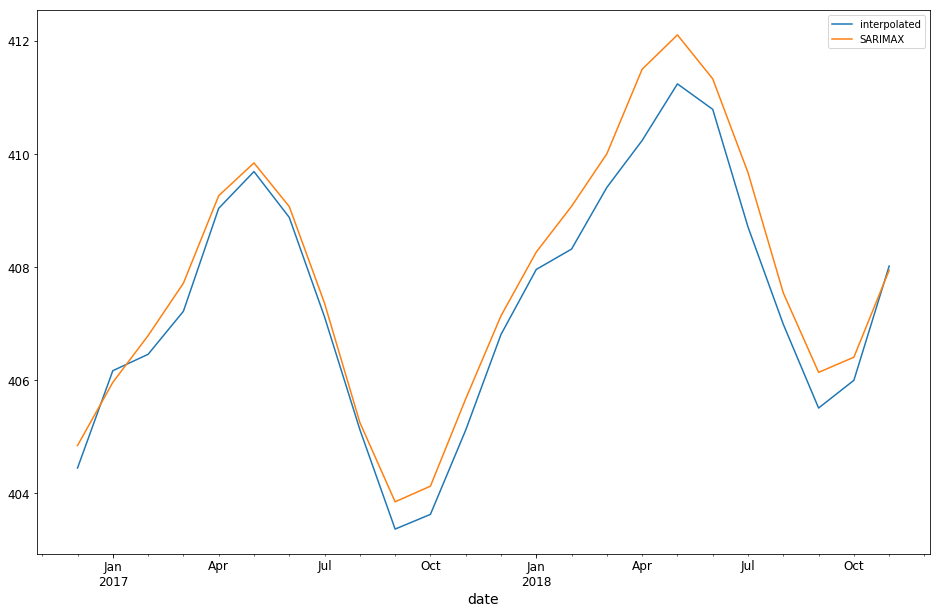

In [58]:
# Plotting test predictions and test data

test['interpolated'].plot(legend = True)
predictions_SARIMA.plot(legend = True)


These predictions look **quite good**, calculating the RMSE followed by the September 2018 and September 2019 forecasts to understand how well the model is performing.

In [59]:
# Evaluating the performance of the model using MSE/RMSE

mse = mean_squared_error(test['interpolated'], predictions_SARIMA)

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  0.5431346246343702


***Purely*** from the standpoint of **RMSE** Holt-Winter's method performs better than SARIMAX

In [60]:
# Calculating the predictions for September 2018 and 2019

predictions_36 = result.predict(start = start ,end = end + 12, typ = 'levels')

In [62]:
predictions_36[20:34]

2018-08-01    407.544705
2018-09-01    406.140236
2018-10-01    406.408227
2018-11-01    407.946530
2018-12-01    409.432445
2019-01-01    410.549570
2019-02-01    411.372429
2019-03-01    412.298689
2019-04-01    413.834718
2019-05-01    414.419593
2019-06-01    413.647198
2019-07-01    411.948198
2019-08-01    409.838642
2019-09-01    408.436775
Freq: MS, dtype: float64

Forecast for September 2018 : 406.14 |
Actuals for September 2018: 405.51 |
**% diff: 0.15%**

Forecast for September 2019 : 408.43 |
Actuals for September 2019: 408.54 |
**% diff: 0.2%**

***SARIMAX also performs extraordinarily well when it comes to forecasts for September 2018 and September 2019*** 


#### Building ACF and PACF Plots 

I'll be using [this very expertly and elaborately written article](https://people.duke.edu/~rnau/411arim3.htm) to interpret these plots

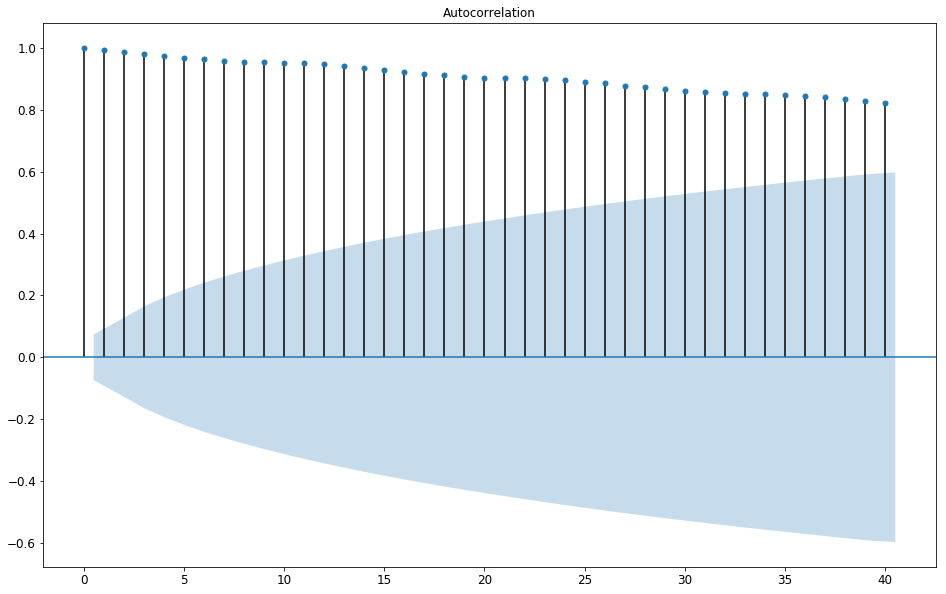

In [69]:
plot_acf(train['interpolated'], lags = 40); # lags should be def. less than #rows

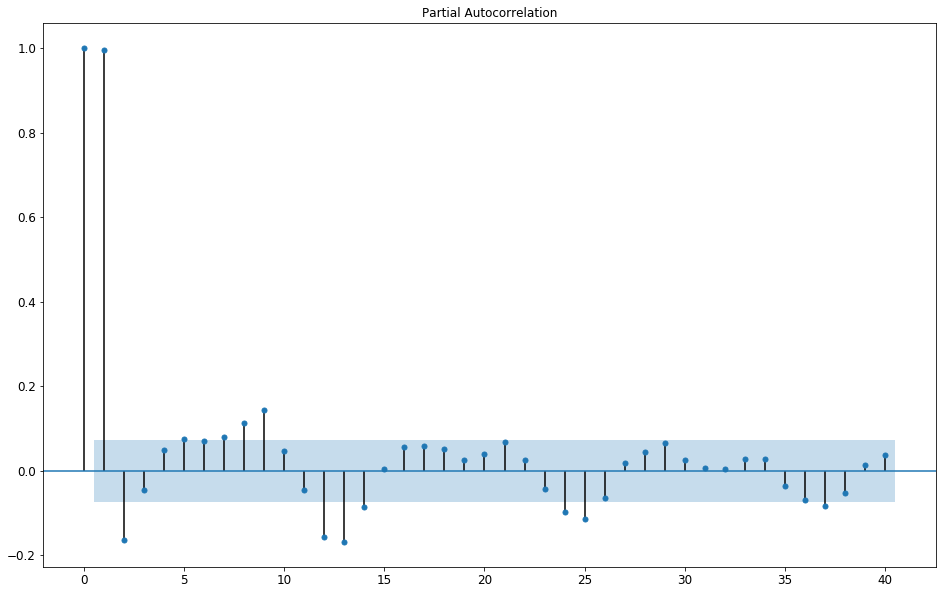

In [70]:
plot_pacf(train['interpolated'], lags = 40); # lags should be def. less than #rows

***

### Misc. Work

Trying out an ARIMA model (no seasonality component model) - just as an experiment

In [63]:
stepwise_fit = auto_arima(train['interpolated'],
                          seasonal = False, trace = True)


/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=2287.903, BIC=2297.017, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1812.482, BIC=1826.152, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1868.784, BIC=1882.454, Fit time=0.028 seconds
Fit ARIMA: order=(2, 1, 0); AIC=1621.166, BIC=1639.393, Fit time=0.036 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=1547.765, BIC=1570.549, Fit time=0.132 seconds
Fit ARIMA: order=(4, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 0); AIC=1547.959, BIC=1575.300, Fit time=0.155 seconds
Total fit time: 0.595 seconds


/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:211: ModelFitWarning: Unable to fit ARIMA for order=(4, 1, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


In [64]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  704
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -768.883
Method:                       css-mle   S.D. of innovations              0.720
Date:                Mon, 04 Nov 2019   AIC                           1547.765
Time:                        20:31:47   BIC                           1570.549
Sample:                             1   HQIC                          1556.570
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1293      0.047      2.775      0.006       0.038       0.221
ar.L1.D.y      0.8933      0.036     24.964      0.000       0.823       0.963
ar.L2.D.y     -0.1564      0.049     -3.202      0.001      -0.252      -0.061
ar.L3.D.y     -0.3199      0.036     -8.927      0.000      -0.390      -0.250
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9041           -0.7373j            1.1666           -0.1089
AR.2            0.9041           +0.7373j            1.1666            0.1089
AR.3           -2.2970           -0.0000j            2.2970           -0.5000
-----------------------------------------------------------------------------
"""

In [65]:
# Implmenting ARIMA

model = ARIMA(train['interpolated'],order = (3,1,0))

result = model.fit()

In [66]:
# Generating Predictions

# Generating predictions
start = len(train)
end = len(train) + len(test) - 1

predictions_ARIMA = result.predict(start = start ,end = end, typ = 'levels')

#IMP: if you choose the default value of "typ" hyperparameter ( 'linear'). you'll get results in terms of differenced data

predictions_ARIMA = predictions_ARIMA.rename('ARIMA')

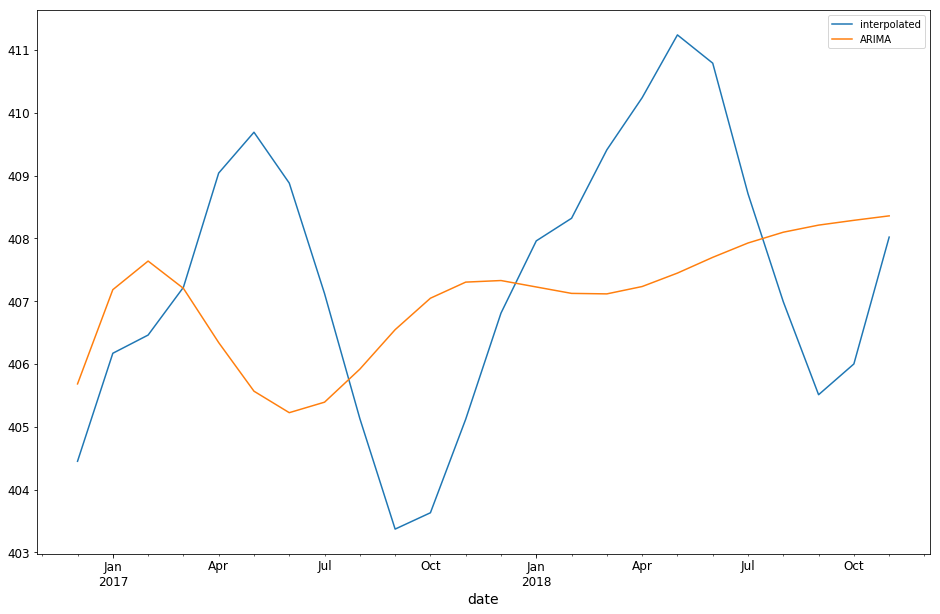

In [68]:
# Plotting test predictions and test data

test['interpolated'].plot(legend = True)
predictions_ARIMA.plot(legend = True)


In [67]:
# Evaluating the performance of the model using MSE/RMSE

mse = mean_squared_error(test['interpolated'], predictions_ARIMA)

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  2.2976984991762883


So, as expected **ARIMA performs poorly on the dataset**